## 3 - Angle Analysis
## Table of Contents
<ul>
<li><a href="#1">Finding Angles of Segments</a></li>
<li><a href="#2">Finding Angles of Fractures</a></li>
<li><a href="#3">Drawing Segments with Angle Lables</a></li>
<li><a href="#4">Histogram of Segment Count vs Angle</a></li>
<li><a href="#5">Histogram of Total Segment Size vs Angle</a></li>
</ul>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import cv2
import numpy as np

<a id='1'></a>
## Finding Angles of Segments

In [2]:
df_segments = pd.read_csv("./output/df_segments_1.csv")

df_segments.head()

,fracture_id,segment_id,X1,Y1,X2,Y2,delta_X,delta_Y,segment_size
0,1528,1528_2,14880.257,8797.5608,14890.307,8777.9108,10.050,-19.6500,22.070908
1,1528,1528_1,14872.006,8806.2608,14880.257,8797.5608,8.251,-8.7000,11.990371
2,1527,1527_4,20349.119,3322.3508,20357.025,3323.7462,7.906,1.3954,8.028199
3,1527,1527_3,20350.282,3311.8852,20349.119,3322.3508,-1.163,10.4656,10.530021
4,1527,1527_2,20338.188,3311.4201,20350.282,3311.8852,12.094,0.4651,12.102940


<img src="in_cell_images/tangent.png">

In [3]:
# Iterate the dataframe of segments and calculate angles with tangent formula, save to dataframe
for index, row in df_segments.iterrows():

    delta_X = row["delta_X"]
    delta_Y = row["delta_Y"]

    if delta_X == 0:
        angle_radian = (np.pi)/2
        angle_degree = 90
    else:
        angle_radian = math.atan(delta_Y/delta_X)
        # fix negative angles
        if angle_radian < 0:
            angle_radian = angle_radian + np.pi
        angle_degree = math.degrees(angle_radian)

    df_segments.loc[index, 'angle_radian'] = angle_radian
    df_segments.loc[index, 'angle_degree'] = angle_degree

In [4]:
df_segments.head()

,fracture_id,segment_id,X1,Y1,X2,Y2,delta_X,delta_Y,segment_size,angle_radian,angle_degree
0,1528,1528_2,14880.257,8797.5608,14890.307,8777.9108,10.050,-19.6500,22.070908,2.043562,117.087491
1,1528,1528_1,14872.006,8806.2608,14880.257,8797.5608,8.251,-8.7000,11.990371,2.329713,133.482698
2,1527,1527_4,20349.119,3322.3508,20357.025,3323.7462,7.906,1.3954,8.028199,0.174700,10.009551
3,1527,1527_3,20350.282,3311.8852,20349.119,3322.3508,-1.163,10.4656,10.530021,1.681468,96.341033
4,1527,1527_2,20338.188,3311.4201,20350.282,3311.8852,12.094,0.4651,12.102940,0.038438,2.202343


In [5]:
# save dataframe to csv
df_segments.to_csv('./output/df_segments_2.csv', index=False)

<a id='2'></a>
## Finding Angles of Fractures

As we now have the angle of each indivulal segment that composes a fracture, we can now calculate the avarage angle of each fracture.

We will calculate a weighted (based on the size of segment) avarage angle and update the df_fractures.

In [6]:
df_fractures = pd.read_csv("./output/df_fractures_2.csv")

In [7]:
for index, row in df_fractures.iterrows():
    fracture_id = row['fracture_id']

    total_size = row['total_size']

    total_weighted = 0
    for index, row in df_segments[df_segments.fracture_id == fracture_id].iterrows():
        weighted = row['segment_size']*row['angle_degree']
        total_weighted += weighted

    weighted_average_angle = total_weighted/total_size

    df_fractures.loc[df_fractures.fracture_id == fracture_id, 'w_average_angle_degree'] = weighted_average_angle

In [8]:
df_fractures.head()

,fracture_id,segments,segments_color,segments_width,Xmin,Xmax,Ymin,Ymax,fracture_height,fracture_length,fracture_direction,total_size,w_average_angle_degree
0,0,"2799.9979,2886.5779,2715.0032,2797.5709,2704.0...",yellow,3,2704.0042,2799.9979,2726.5764,2886.5779,160.0015,95.9937,Vertical,194.911960,59.174355
1,1,"2857.0003,2830.5703,2759.9982,2772.5739,2755.0...",blue,3,2755.0029,2857.0003,2736.5771,2830.5703,93.9932,101.9974,Horizontal,149.359400,43.338584
2,2,"2612.9964,2824.5755,2708.7733,2805.8089",blue,3,2612.9964,2708.7733,2805.8089,2824.5755,18.7666,95.7769,Horizontal,97.598155,168.913872
3,3,"2655.0037,2794.5735,2613.9955,2756.5784",blue,3,2613.9955,2655.0037,2756.5784,2794.5735,37.9951,41.0082,Horizontal,55.904383,42.815860
4,4,"3004.443,2762.0149,3084.76,2774.2514,3121.4356...",blue,3,3004.4430,3121.4356,2762.0149,2778.0103,15.9954,116.9926,Horizontal,118.111506,7.785202


In [9]:
# save dataframe to csv
df_fractures.to_csv('./output/df_fractures_3.csv', index=False)

<a id='3'></a>
## Drawing Segments with Angle Labels

In [10]:
# Reading the image
image = cv2.imread('Global_20190321_ShapeV20_200kfacets_FB3.png')

In [11]:
# flip the image vertically
# this is beacuse our coordinates are currently presented on the 'Cartesian Coordinates System'
# but in 'Computer Graphics Coordinate System' the coordinates are flipped on the Y axis
image = cv2.flip(image, 0)

In [12]:
# Draw segments and labels
for index, row in df_segments.iterrows():

    X1, Y1, X2, Y2 = int(row['X1']), int(row['Y1']), int(row['X2']), int(row['Y2'])
    
    angle_degree=str(int(row['angle_degree']))
    
    start_point = (X1, Y1)
    end_point = (X2, Y2)

    # Green color in BGR
    line_color = (0, 255, 0)

    # Line thickness
    thickness=2

    image=cv2.line(image, start_point, end_point, line_color, thickness)

    center_point = (int((X1+X2)/2), int((Y1+Y2)/2))

    label_angle = np.zeros((11,24,3),np.uint8)
    # White color in BGR
    text_color = (255, 255, 255)
    # font
    font = cv2.FONT_HERSHEY_SIMPLEX
    # fontScale
    fontScale = 0.4
    # Using cv2.putText() method
    label_angle = cv2.putText(label_angle, angle_degree, (0,9), font, fontScale, text_color)
    #label_angle = cv2.flip(label_angle, 0)
    label_angle = cv2.flip(label_angle, 0)

    x, y = center_point[0], center_point[1]
    h, w = label_angle.shape[:2]
    image[y:y+h, x:x+w] = label_angle

In [13]:
image = cv2.flip(image, 0)

cv2.imwrite('./output/bennu_angles.jpg', image)

True

### Sample from the Output
<img src="in_cell_images/angles.png">

<a id='4'></a>
## Histogram of Segment Count vs Angle

In [14]:
number_of_bins = 18

In [15]:
bin_edges_degree = np.linspace(0, 180, number_of_bins+1)

bin_edges_degree

array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
       110., 120., 130., 140., 150., 160., 170., 180.])

### Histogram Values

In [16]:
pd.cut(x=df_segments['angle_degree'], bins=bin_edges_degree).value_counts().sort_index()

(0.0, 10.0]        99
(10.0, 20.0]      104
(20.0, 30.0]      121
(30.0, 40.0]      143
(40.0, 50.0]      158
(50.0, 60.0]      176
(60.0, 70.0]      216
(70.0, 80.0]      193
(80.0, 90.0]      233
(90.0, 100.0]     223
(100.0, 110.0]    209
(110.0, 120.0]    242
(120.0, 130.0]    233
(130.0, 140.0]    291
(140.0, 150.0]    196
(150.0, 160.0]    168
(160.0, 170.0]    147
(170.0, 180.0]     76
Name: angle_degree, dtype: int64

### Bar Histogram

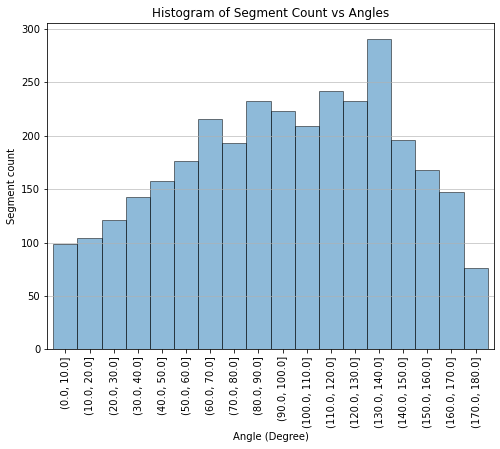

In [17]:
plt.figure(figsize=(8, 6))

#ax = df_segments.angle_degree.plot.hist(bins=18, alpha=0.5, histtype='bar', ec='black')

ax = pd.cut(x=df_segments['angle_degree'], bins=bin_edges_degree).value_counts().sort_index().plot(kind='bar', width=1.0, alpha=0.5, ec='black')

plt.grid(axis='y', alpha=0.75)

#plt.xticks(bin_edges_degree)

# set chart title
ax.set_title('Histogram of Segment Count vs Angles')
# set x, y axes labels
ax.set_xlabel("Angle (Degree)")
ax.set_ylabel("Segment count")

plt.show()

### Polar Histogram

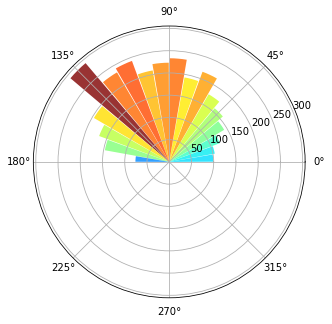

In [18]:
number_of_bins=18

bin_edges_radian = np.linspace(0.0, np.pi, (number_of_bins+1))

bin_labels_radian = np.zeros(number_of_bins)

for i in range(number_of_bins):
  bin_labels_radian[i] = (bin_edges_radian[i] + bin_edges_radian[i+1])/2

df_segments['radian_category']=pd.cut(x=df_segments['angle_radian'], bins=bin_edges_radian, labels=bin_labels_radian)

bin_values_radian=pd.value_counts(df_segments['radian_category']).sort_index().values

bottom = 0
max_height = bin_values_radian.max()

width = (np.pi) / (number_of_bins+1)

plt.figure(figsize=(5,5))

ax = plt.subplot(111, polar=True)
bars = ax.bar(bin_labels_radian, bin_values_radian, width=width, bottom=bottom)

# Use custom colors and opacity
for r, bar in zip(bin_values_radian, bars):
    bar.set_facecolor(plt.cm.jet(r / max_height))
    bar.set_alpha(0.8)

plt.show()

<a id='5'></a>
## Histogram of Total Segment Size vs Angle

In [19]:
number_of_angle_bins = 18

In [20]:
bin_edges_angle_degree = np.linspace(0, 180, number_of_angle_bins+1)

bin_edges_angle_degree

array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
       110., 120., 130., 140., 150., 160., 170., 180.])

In [21]:
df_segments['bin_angle_degree'] = pd.cut(x=df_segments['angle_degree'], bins=bin_edges_angle_degree)

In [22]:
df_segments.head()

,fracture_id,segment_id,X1,Y1,X2,Y2,delta_X,delta_Y,segment_size,angle_radian,angle_degree,radian_category,bin_angle_degree
0,1528,1528_2,14880.257,8797.5608,14890.307,8777.9108,10.050,-19.6500,22.070908,2.043562,117.087491,2.007129,"(110.0, 120.0]"
1,1528,1528_1,14872.006,8806.2608,14880.257,8797.5608,8.251,-8.7000,11.990371,2.329713,133.482698,2.356194,"(130.0, 140.0]"
2,1527,1527_4,20349.119,3322.3508,20357.025,3323.7462,7.906,1.3954,8.028199,0.174700,10.009551,0.261799,"(10.0, 20.0]"
3,1527,1527_3,20350.282,3311.8852,20349.119,3322.3508,-1.163,10.4656,10.530021,1.681468,96.341033,1.658063,"(90.0, 100.0]"
4,1527,1527_2,20338.188,3311.4201,20350.282,3311.8852,12.094,0.4651,12.102940,0.038438,2.202343,0.087266,"(0.0, 10.0]"


### Histogram Values

In [23]:
df_segments.groupby('bin_angle_degree')['segment_size'].sum().head()

bin_angle_degree
(0.0, 10.0]     3282.387885
(10.0, 20.0]    3444.950454
(20.0, 30.0]    3987.912818
(30.0, 40.0]    4100.280563
(40.0, 50.0]    4477.289006
Name: segment_size, dtype: float64

### Bar Histogram

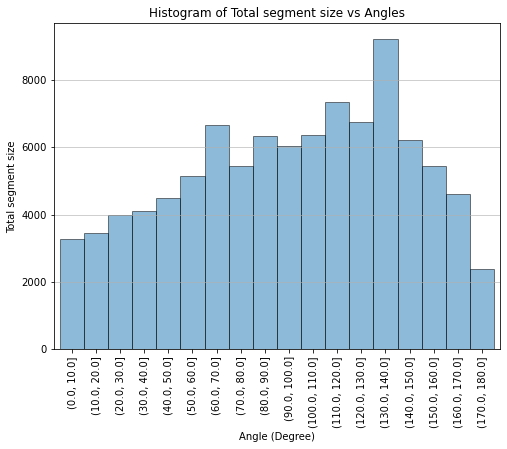

In [24]:
plt.figure(figsize=(8, 6))

ax = df_segments.groupby('bin_angle_degree')['segment_size'].sum().plot(kind='bar', width=1.0, alpha=0.5, ec='black')

plt.grid(axis='y', alpha=0.75)

# set chart title
ax.set_title('Histogram of Total segment size vs Angles')
# set x, y axes labels
ax.set_xlabel("Angle (Degree)")
ax.set_ylabel("Total segment size")

plt.show()